# Make Calibration WAV Files
## By Terry Bondy, VA3TYB

In [1]:
printf(strftime ("Last updated: %A %e %B %Y %Z", localtime (time())))
%plot --format svg
# format long

Last updated: Friday 27 December 2019 UTC

In [2]:
fcLow = 200;
fcHigh = 2600;

In [3]:
fcMid = sqrt(fcHigh/fcLow) * fcLow

fcMid =  721.11


In [4]:
F = fcLow:1:fcHigh;
columns(F)
sqrt(fcLow*fcHigh)

ans =  2401
ans =  721.11


In [5]:
J = log(F);
jmin = min(J)
jmax = max(J)
jmid = mean([jmin, jmax])
H = abs(J - jmid);
hmin = min(H)
hmax = max(H)

jmin =  5.2983
jmax =  7.8633
jmid =  6.5808
hmin =    1.5291e-04
hmax =  1.2825


In [6]:
# What are the factors of the number of frequencies?
Factors = factor(columns(F)-1);
# Determine the possible intervals by looking at all products of choose
Possible_Intervals = unique(cell2mat(arrayfun(@(t) unique(prod(nchoosek(Factors, t), 2))', [1:columns(Factors)], "UniformOutput", false)))
# Then pick one of them
intervals = Possible_Intervals(9)

Possible_Intervals =

 Columns 1 through 11:

      2      3      4      5      6      8     10     12     15     16     20

 Columns 12 through 22:

     24     25     30     32     40     48     50     60     75     80     96

 Columns 23 through 33:

    100    120    150    160    200    240    300    400    480    600    800

 Columns 34 and 35:

   1200   2400

intervals =  15


Sort F so that it is in the order log distance from fcMid, and also compute what interval they are in.

In [7]:
G = sortrows(horzcat(H', ceil(intervals*H'/hmax), F'), [1]);

Sample a number of rows

In [8]:
format long g
Sample = vertcat(G(1:floor(end/intervals):end,:), G(rows(G),:))
format

Sample =

  0.000152907993856033                     1                   721
     0.111291697227823                     2                   806
     0.220490989192815                     3                   899
     0.326963233703332                     4                   520
     0.430421942071562                     6                  1109
     0.529904077700022                     7                  1225
     0.624843131131558                     8                  1347
     0.714323988345509                     9                   353
     0.800048529486476                    10                   324
     0.880348471888118                    11                   299
     0.956774539091467                    12                   277
      1.02907015563475                    13                  2018
      1.09753431122808                    13                  2161
       1.1624776555502                    14                  2306
      1.22420577060679                    15        

In [9]:
G(find(G(:,3)==721),:)

ans =

   1.5291e-04   1.0000e+00   7.2100e+02



In [10]:
sum(G(:,2) == 1)
sum(G(:,2) == 1:1:intervals)

ans =  123
ans =

 Columns 1 through 13:

   123   125   126   129   132   138   142   151   156   167   176   188   201

 Columns 14 and 15:

   215   232



Ensure that there are no values of H that are duplicated, meaning that there are a pair of frequencies, one each on each side of fcMid, that are equidistant log-wise, from fcMid. If there are, then we would have to be careful how we subdivide F later on. If there is at least one, then the following result will be zero.

In [11]:
sort(abs(diff(H)))(1)

ans =    3.8469e-04


Helps that fcMid is not integral, like members of F.

In [12]:
sampleRate = 16000;
period = 10;
T = 0:1/sampleRate:period;

In [13]:
TestFreq = [ G(1,3) ]
TestPhi = [ 0 ]

TestFreq =  721
TestPhi = 0


In [14]:
cosArg = 2*pi*TestFreq';
tic = time();
Sig = arrayfun(@(t) sum(cos(cosArg*t + TestPhi')), T);
printf("toc: %d seconds", time() - tic)

toc: 2.44878 seconds

In [15]:
tic = time();
TestFreq = [ G(1,3) ]
TestPhi = [ 0 ]
##-cosArg = 2*pi*TestFreq';
##-Sig = arrayfun(@(t) sum(cos(cosArg*t + TestPhi')), T);
cosArg = 2*pi*TestFreq * T + TestPhi;
Sig = cos(cosArg);
size(Sig)
printf("toc: %d seconds\n", time() - tic)
max(abs(Sig))
numIndexes = 120;
for firstIndex = 2:numIndexes:rows(G)
  TestFreq = G(firstIndex:firstIndex+numIndexes-1, 3);
  ##- TestPhi = 2*pi*rand(rows(TestFreq),1);
  # columns(TestFreq)
  # rows(TestFreq)
  # TestFreq(1,1)
  ##- cosArg = 2*pi*TestFreq';
  tic = time();
  TestPhi = 2*pi*rand(rows(TestFreq),1);
  # TestPhi = zeros(rows(TestFreq),1);
  cosArg = 2*pi*TestFreq * T + TestPhi;
  Sig = sum(cos(cosArg)) + Sig;
  size(Sig)
  ##- Sig = arrayfun(@(t) sum(cos(cosArg*t + TestPhi')), T);
  printf("toc: %d seconds\n", time() - tic)
  # printf("%f ", max(abs(Sig)))
  max(abs(Sig))
  # printf("%d %d\n", firstIndex, firstIndex + numIndexes - 1)
endfor

TestFreq =  721
TestPhi = 0
ans =

        1   160001

toc: 0.031235 seconds
ans =  1
ans =

        1   160001

toc: 0.813632 seconds
ans =  26.825
ans =

        1   160001

toc: 0.824925 seconds
ans =  36.480
ans =

        1   160001

toc: 0.852447 seconds
ans =  50.239
ans =

        1   160001

toc: 0.827592 seconds
ans =  55.488
ans =

        1   160001

toc: 0.819552 seconds
ans =  72.811
ans =

        1   160001

toc: 0.805989 seconds
ans =  81.925
ans =

        1   160001

toc: 0.827082 seconds
ans =  91.967
ans =

        1   160001

toc: 0.821181 seconds
ans =  89.515
ans =

        1   160001

toc: 0.817895 seconds
ans =  95.881
ans =

        1   160001

toc: 0.79733 seconds
ans =  99.090
ans =

        1   160001

toc: 0.792202 seconds
ans =  109.19
ans =

        1   160001

toc: 0.771829 seconds
ans =  107.01
ans =

        1   160001

toc: 0.778729 seconds
ans =  116.51
ans =

        1   160001

toc: 0.763225 seconds
ans =  116.46
ans =

        1   160001

toc: 0

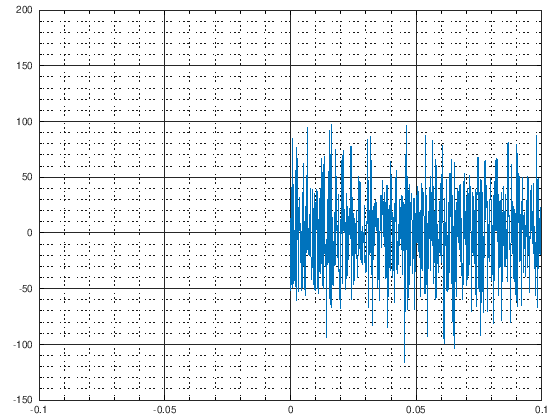

In [16]:
plot(T, Sig)
grid on
grid minor
axis([-0.1,+0.1], "tic")

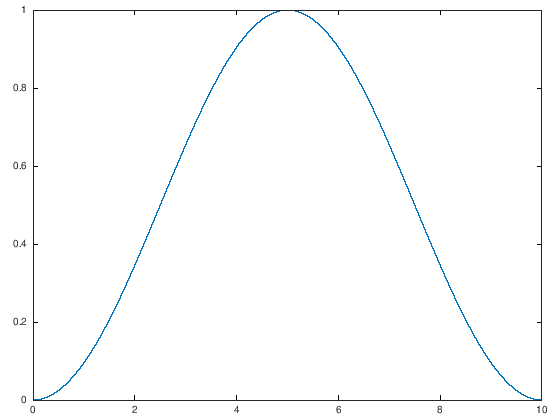

In [17]:
RC = (1 - cos(2*pi*T/period))/2;
plot(T, RC);

In [18]:
E_cos_pulse = fftshift(fft(RC .* Sig, sampleRate*period*10 + 1));
# E_cos_pulse = fftshift(fft(RC .* Sig));
F_base = linspace(-sampleRate/2, sampleRate/2, columns(E_cos_pulse));

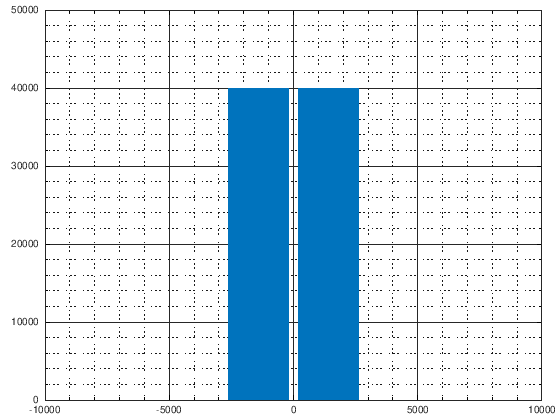

In [19]:
plot(F_base, sqrt(E_cos_pulse .* conj(E_cos_pulse)))
grid on
grid minor
# axis([fcLow-10 fcLow+10], "tic")